# Object Localization

In addition to classifying images (this is an image of a dog, this is an image of a cat...) CNN's can be used to determine the location of something in an image. Generally speaking localization entails bounding the object in question with a tight rectangle. There are multiple forms of this, including:

* Single object localization: identify a single object and localize it within a bounding box.
* Multiple object localization (sometimes called Object Detection): Identify and bound all relevant objects within a rectangle (i.e one bounding box per object)
* Semantic segmentation: identify exactly which pixels belong to objects (instead of a bounding box)

![](img/pet_annotations.jpg)

> Image source Oxford Pet dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

For each of these three categories, a network might be designed to detect many different classes of objects or only identify a single kind of object. For example, you could design a network that:

* Only detects the location of a single dog. 
* Detects the location of a dog, or a cat, and classifies it as such.
* Detects the location of all dogs and cats, but doesn't classify them as dog or cat.
* Detects the location of all dogs and cats and labels each instance as dog or cat. 
* ... and so on ...

The same networks that perform well on classification tasks can often be re-purposed to perform localization, but  the output layers need to change significantly. As you might imagine, the complexity of our solutions increase as the complexity of the task increases: Detecting the location of the dog in a dataset that's all images of dogs is much easier than localizing all of the objects beloinging to 1 of 1000 target classes. Similarly, detecting a bounding box is easier than detecting exactly which pixels contain the object in question.

In this section we are going to limit ourselves to **single object localization**. Additional study materials are provided in the readme regarding multiple object localization.

Often, setting up the data is one of the most tediuous and challenging aspects of an ML project. Lets quickly take a look at the data provided before we start processing it. 

The images are all photos of an individual animal. There are ~200 samples of each type of animal. They are all dogs or cats of varying breeds. The shape of the image and positioning, posture, and angle of the animal varies from picture to picture. 

![](img/Abyssinian_223.jpg)
![](img/american_bulldog_138.jpg)
![](img/basset_hound_61.jpg)


The various sizes present a challenge, since our net expects each image to have the same shape. In the past we handled this by padding the image to square then reshapping them. That same strategy can work here (and we have to do SOMETHING) but the bounding boxes provided map to the original input, so we have to keep that in mind. 

Next, the image-to-class mapping is in a CSV file, here are some sample entries:

```
Abyssinian_113 1 1 1
yorkshire_terrier_95 37 2 25
wheaten_terrier_196 36 2 24
Siamese_49 33 1 11
```

The columns are:

```
image_name class_id species_id breed_id
```

Though the dataset gives us the ability to classify each breed of cat/dog individually, we're going to make things a bit easier just focus on species_id, 1 for cat, 2 for dog. 


Finally, the bounding box annotations are in an XML format called PASCAL VOC. There are specialized readers that can parse this format specifically, but we can also use Pythons built in XML parser without much trouble. 

```xml
<?xml version="1.0" encoding="UTF-8"?>
<annotation>
   <folder>OXIIIT</folder>
   <filename>Abyssinian_1.jpg</filename>
   <source>
      <database>OXFORD-IIIT Pet Dataset</database>
      <annotation>OXIIIT</annotation>
      <image>flickr</image>
   </source>
   <size>
      <width>600</width>
      <height>400</height>
      <depth>3</depth>
   </size>
   <segmented>0</segmented>
   <object>
      <name>cat</name>
      <pose>Frontal</pose>
      <truncated>0</truncated>
      <occluded>0</occluded>
      <bndbox>
         <xmin>333</xmin>
         <ymin>72</ymin>
         <xmax>425</xmax>
         <ymax>158</ymax>
      </bndbox>
      <difficult>0</difficult>
   </object>
</annotation>
```

In [1]:
# All the imports:
from collections import namedtuple
import csv

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras import backend as K
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, image as keras_image
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

# This is new, the XML parsing library comes with Python
import xml.etree.ElementTree as ET

Using TensorFlow backend.


In [2]:
# First, we have to download and prepare the data. We're using the Oxford Pet dataset
# linked above. You need the "dataset" and the "groundtruth data" listed under Downloads

# Modify these to fit wherever you save the data.
PATH_TO_IMAGES = 'pets_dataset/images'
PATH_TO_CLASS_LIST = 'pets_dataset/annotations/list.txt'
PATH_TO_XML_ANNOTATIONS = 'pets_dataset/annotations/xmls'

# Change if you wish. 
TARGET_SIZE = (224, 224)

In [3]:
# Just to make the code a bit easier to read.
BoundingBox = namedtuple('BoundingBox', 'xmin ymin xmax ymax')

# A function to read the XML and return (xmin, ymin, xmax, ymax)
def get_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()
    
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)

    return BoundingBox(xmin, ymin, xmax, ymax)

In [4]:
# A function to reshape the images and appropriately transform
# the bounding box for that image. Much of this comes from last lab
# and should look familiar.
def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    # When we pad the image to square, we have to adjust all the bounding box
    # values by the amounts we added on the left or top. The "bonus" pads are
    # always done on the bottom and right so we can ignore them in terms of the box.
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad
    
    # When we resize the image, it's by some scalar. We have to apply that 
    # scalar to the bounding box as well. We may lose a small amount of precision
    # when we do this, but not so much that it'll hurt our predictions
    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

        if bounding_box is not None:
            new_xmin = new_xmin * width_scale
            new_xmax = new_xmax * width_scale
            new_ymin = new_ymin * height_scale
            new_ymax = new_ymax * height_scale
    
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function. 
    if bounding_box is None:
        return image_data, None
    
    return (image_data, BoundingBox(new_xmin, new_ymin, new_xmax, new_ymax))

In [5]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well as it's transformed bounding box
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_xml = os.path.join(PATH_TO_XML_ANNOTATIONS, sample_name + '.xml')

    original_bounding_box = get_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
    
    return (image_data, bounding_box)

In [6]:
# Given the image data, plot the data with the bounding box.
# for testing/verification purposes. 
def plot_with_box(image_data, bounding_box, compare_box=None):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_data)

    # Create a Rectangle patch. 
    rect_red = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect_red)

    if compare_box is not None:
        rect_blue = patches.Rectangle((compare_box.xmin, compare_box.ymin),
                             compare_box.xmax - compare_box.xmin,
                             compare_box.ymax - compare_box.ymin,
                             linewidth=2, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_blue)

    plt.show()

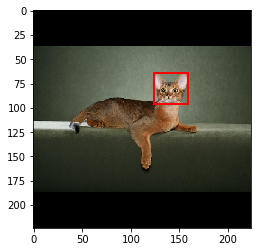

In [7]:
# Lets take a look at what we've done:
sample_name = 'Abyssinian_1'

image, bounding_box = prepare_sample_from_name(sample_name)
plot_with_box(image, bounding_box)

In [8]:
# Okay, lets get all our samples processed. After this we'll prepare the 
# data and labels for our network and perform a validation split.
processed_data = []

# Processing all this data takes some time... 
# Took my laptop roughly 5 minutes
with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Use a try/except block to ignore such samples
        try:
            image, bounding_box = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # This actually happens quite a lot, as you can see in the output.
            # we end up with 7349 samples.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1.
        # Makes things a little easier to process
        data_tuple = (image, int(species) - 1, bounding_box)
        processed_data.append(data_tuple)
        
print(f'Processed {len(processed_data)} samples')

# Make it a numpy array
processed_data = np.array(processed_data)

No annotations for Abyssinian_104: skipped.
No annotations for Bengal_111: skipped.
No annotations for samoyed_10: skipped.
No annotations for Bengal_175: skipped.
No annotations for Egyptian_Mau_14: skipped.
No annotations for Egyptian_Mau_156: skipped.
No annotations for Egyptian_Mau_186: skipped.
No annotations for Ragdoll_199: skipped.
No annotations for saint_bernard_15: skipped.
No annotations for Abyssinian_201: skipped.
No annotations for Abyssinian_202: skipped.
No annotations for Abyssinian_204: skipped.
No annotations for Abyssinian_205: skipped.
No annotations for Abyssinian_206: skipped.
No annotations for Abyssinian_207: skipped.
No annotations for Abyssinian_20: skipped.
No annotations for Abyssinian_210: skipped.
No annotations for Abyssinian_212: skipped.
No annotations for Abyssinian_213: skipped.
No annotations for Abyssinian_215: skipped.
No annotations for Abyssinian_216: skipped.
No annotations for Abyssinian_217: skipped.
No annotations for Abyssinian_219: skippe

No annotations for english_setter_61: skipped.
No annotations for english_setter_62: skipped.
No annotations for english_setter_63: skipped.
No annotations for english_setter_64: skipped.
No annotations for english_setter_65: skipped.
No annotations for english_setter_66: skipped.
No annotations for english_setter_67: skipped.
No annotations for english_setter_68: skipped.
No annotations for english_setter_69: skipped.
No annotations for english_setter_6: skipped.
No annotations for english_setter_70: skipped.
No annotations for english_setter_71: skipped.
No annotations for english_setter_72: skipped.
No annotations for english_setter_73: skipped.
No annotations for english_setter_74: skipped.
No annotations for english_setter_75: skipped.
No annotations for english_setter_76: skipped.
No annotations for english_setter_77: skipped.
No annotations for english_setter_78: skipped.
No annotations for english_setter_79: skipped.
No annotations for english_setter_7: skipped.
No annotations 

No annotations for Russian_Blue_24: skipped.
No annotations for Russian_Blue_253: skipped.
No annotations for Russian_Blue_258: skipped.
No annotations for Russian_Blue_262: skipped.
No annotations for Russian_Blue_263: skipped.
No annotations for Russian_Blue_264: skipped.
No annotations for Russian_Blue_27: skipped.
No annotations for Russian_Blue_28: skipped.
No annotations for Russian_Blue_29: skipped.
No annotations for Russian_Blue_30: skipped.
No annotations for Russian_Blue_31: skipped.
No annotations for Russian_Blue_32: skipped.
No annotations for Russian_Blue_33: skipped.
No annotations for Russian_Blue_34: skipped.
No annotations for Russian_Blue_35: skipped.
No annotations for Russian_Blue_36: skipped.
No annotations for Russian_Blue_38: skipped.
No annotations for Russian_Blue_40: skipped.
No annotations for Russian_Blue_41: skipped.
No annotations for Russian_Blue_43: skipped.
No annotations for Russian_Blue_44: skipped.
No annotations for Russian_Blue_45: skipped.
No an

924 dog


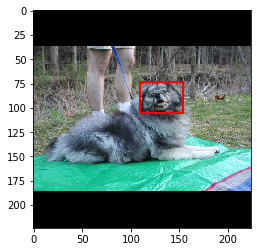

1755 dog


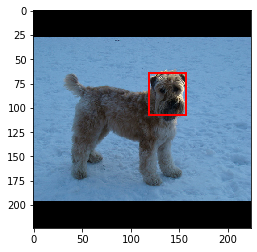

1529 dog


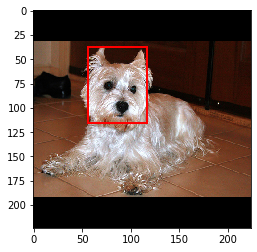

959 dog


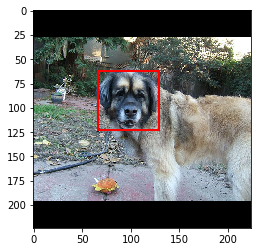

2623 dog


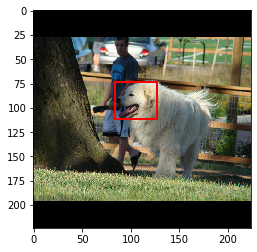

In [9]:
# Lets just do some random spot checking
for _ in range(5):
    i = np.random.randint(len(processed_data))
    image, species, bounding_box = processed_data[i]
    
    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")
        
    plot_with_box(image, bounding_box)

In [10]:
# We still have to split our data. We also have to create TWO separate 
# label groups, since we're going to handle the classificaton and 
# bounding box predictions separately. 
x_train = []
y_class_train = []
y_box_train = []

x_validation = []
y_class_validation = []
y_box_validation = []

validation_split = 0.2

# Notice that we're applying the preprocess_input function here:
for image, species, bounding_box in processed_data:
    if np.random.random() > validation_split:
        x_train.append(preprocess_input(image))
        y_class_train.append(species)
        y_box_train.append(bounding_box)
    else:
        x_validation.append(preprocess_input(image))
        y_class_validation.append(species)
        y_box_validation.append(bounding_box)
        
x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)

x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

In [11]:
# We don't have a TON of data. It's also much harder to use image augmentation
# since we'd have to apply the transformation to the bounding box data as well
# Lets still use transfer learning
# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________

In [12]:
# okay, now when we compile the model we have to provide it with two loss functions
# one for each output layer.

model.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

Instructions for updating:
Use tf.cast instead.
Train on 2921 samples, validate on 750 samples
Epoch 1/3
2921/2921 [==============================] - 571s 195ms/step - loss: 1205.3745 - dense_1_loss: 0.3709 - dense_2_loss: 908.6766 - dense_1_acc: 0.8271 - dense_2_acc: 0.7768 - val_loss: 1136.9008 - val_dense_1_loss: 0.9201 - val_dense_2_loss: 400.7894 - val_dense_1_acc: 0.7413 - val_dense_2_acc: 0.8160
Epoch 2/3
2921/2921 [==============================] - 635s 217ms/step - loss: 368.8871 - dense_1_loss: 0.1537 - dense_2_loss: 245.9360 - dense_1_acc: 0.9387 - dense_2_acc: 0.8429 - val_loss: 542.2328 - val_dense_1_loss: 0.1881 - val_dense_2_loss: 391.7131 - val_dense_1_acc: 0.9240 - val_dense_2_acc: 0.8480
Epoch 3/3
2921/2921 [==============================] - 627s 215ms/step - loss: 215.7185 - dense_1_loss: 0.0759 - dense_2_loss: 154.9873 - dense_1_acc: 0.9764 - dense_2_acc: 0.8757 - val_loss: 443.4577 - val_dense_1_loss: 0.1095 - val_dense_2_loss: 355.8702 - val_dense_1_acc: 0.9560 - 

Called it a Cat


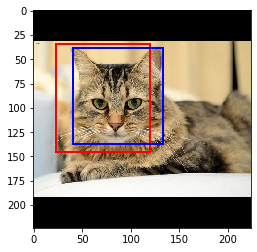

Called it a dog


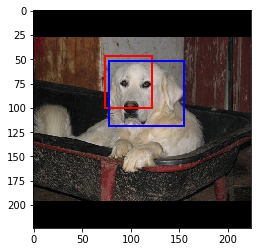

Called it a dog


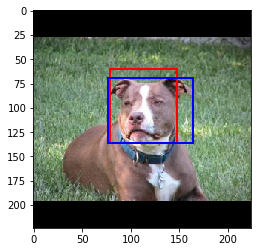

Called it a dog


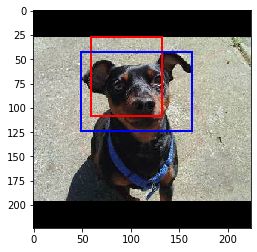

Called it a dog


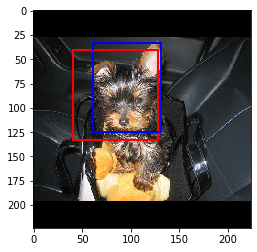

Called it a dog


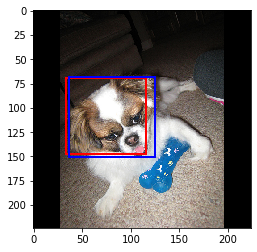

Called it a dog


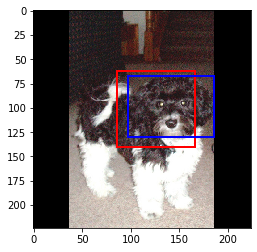

Called it a dog


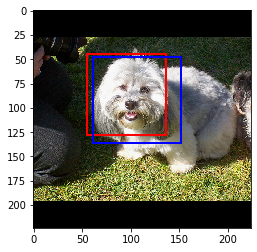

Called it a dog


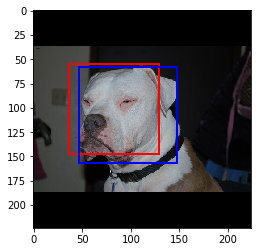

Called it a dog


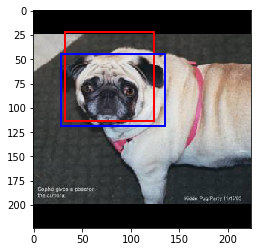

Called it a Cat


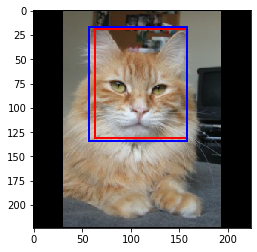

Called it a dog


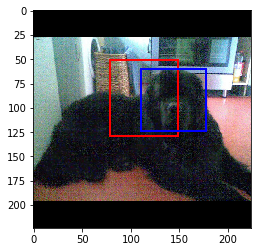

Called it a dog


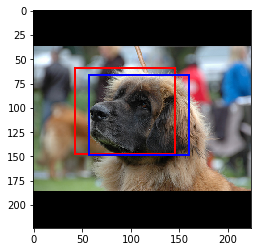

Called it a Cat


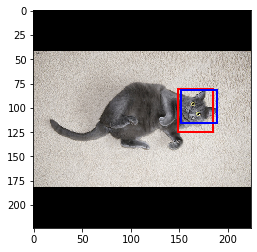

Called it a dog


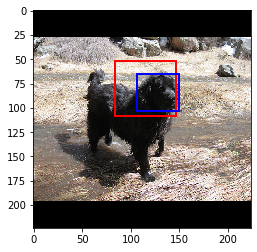

Called it a Cat


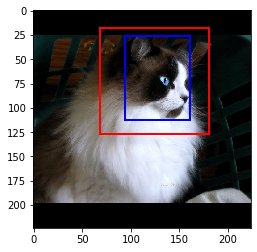

Called it a dog


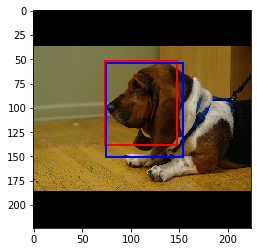

Called it a dog


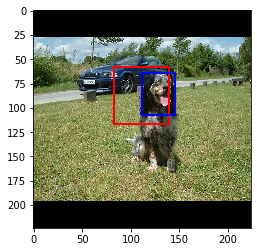

Called it a Cat


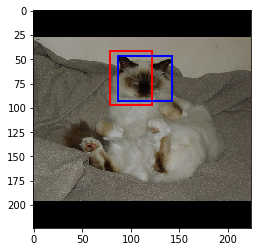

Called it a dog


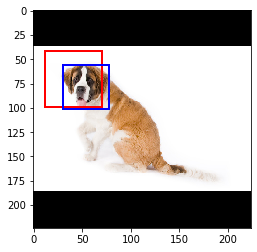

In [13]:
# Fetching the non mobile-net processed images so we can actually see them
for _ in range(20):
    i = np.random.randint(len(processed_data))
    img, species, true_bounding_box = processed_data[i]

    pred = model.predict(np.array([preprocess_input(img)]))

    if pred[0][0] < .5:
        print("Called it a Cat")
    else:
        print("Called it a dog")


    # Thre true box is in blue, predicted in red
    plot_with_box(img, BoundingBox(*pred[1][0]), true_bounding_box)

pets_dataset/images/Ragdoll_199.jpg
Called it a Cat


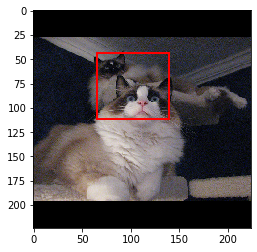

pets_dataset/images/saint_bernard_15.jpg
Called it a dog


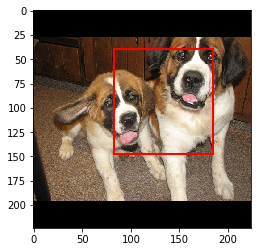

pets_dataset/images/Abyssinian_201.jpg
Called it a dog


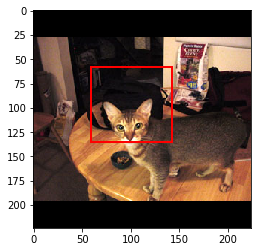

pets_dataset/images/american_bulldog_35.jpg
Called it a dog


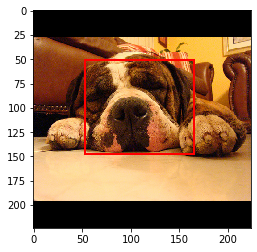

pets_dataset/images/american_pit_bull_terrier_191.jpg
Called it a dog


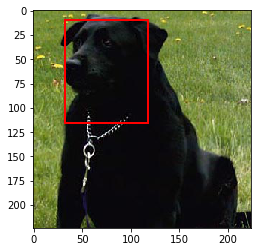

pets_dataset/images/basset_hound_200.jpg
Called it a dog


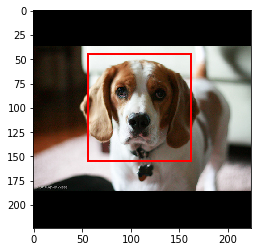

pets_dataset/images/beagle_202.jpg
Called it a dog


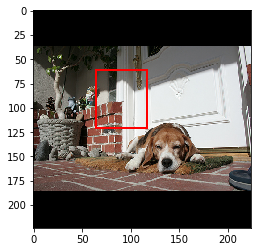

In [14]:
# Lets see how it does on some images that we didn't have the bounding boxes for
# so haven't been part of validation or training data!

unknown_samples = [
    'Ragdoll_199',
    'saint_bernard_15',
    'Abyssinian_201',
    'american_bulldog_35',
    'american_pit_bull_terrier_191',
    'basset_hound_200',
    'beagle_202'
]

for sample_name in unknown_samples:
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    print(path_to_image)
    img, _ = resize_image_with_bounds(path_to_image, target_size=TARGET_SIZE)
    pred = model.predict(np.array([preprocess_input(img)]))
    
    if pred[0][0] < .5:
        print("Called it a Cat")
    else:
        print("Called it a dog")


    # We have no idea what the "true bounding box" should be
    # but we can decide if we think our network is doing okay
    plot_with_box(img, BoundingBox(*pred[1][0]))


Obviously, the predictions are not perfect, but this is honestly shockingly good for a single training epoch. We could look to improve these results a number of ways, many of which are in the additional resources section. To improve these results consider: 

* Implementing the Intersection over Union (IoU) loss function (see additional resources).
* Implementing (or finding a pretrained) YOLO network.
* Implementing data augmentation in a way that maintains preserves the bounding box
* Getting more data the old fashioned way. 
* See further resources for more...
